<a href="https://colab.research.google.com/github/starscream1114-source/ADALL_github/blob/main/Copy_of_ADALL_Practical_Test_Revision_Regression_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Practical Test Revision (Regression): Predicting Number of Failed Subjects

This notebook revises a **regression workflow** using a target that is a **special case**:

- Your target is a **count**: number of subjects failed (based on scores below **10** from **G1, G2, G3**).
- Because the target is an **integer count** (often 0, 1, 2, 3), it can *feel* similar to classification.
- However, you are still doing **regression** because the model outputs a **numeric value** and you evaluate using **regression metrics**.

## How to think about this target (important for revision)

| Perspective | What it means here | Typical choice |
|---|---|---|
| Regression view | Predict a numeric count (can be 0–3, but model can output non-integers) | MSE / MAE / RMSE, R² |
| Classification-like view (edge case) | If you convert counts into categories (e.g., 0 vs ≥1) you can classify | Accuracy, F1, ROC-AUC |

### Caveat you must remember
Even when the target behaves like classes, **do not switch to classification** unless the task explicitly asks you to do so.

## Practical test habits
- Keep code **readable** and **step-by-step**.
- Add short notes explaining **why** a step is needed.
- When unsure: print shapes, check missing values, and check your target distribution.

---


# ADALL Practical Test Revision Lab (Regression)

**Dataset:** Student Performance Data (KaggleHub)  
**Goal:** Build a simple, sensible regression model and explain your choices.

---

## What you will practise today
By the end of this session, you should be able to:

- Load a dataset from KaggleHub and do basic checks (Section 1)
- Define a clear **classification target** from raw columns (Section 1)
- Split data properly without leakage (Section 2)
- Build a **baseline classification pipeline** (Section 2)
- Evaluate using **confusion matrix + precision/recall/F1** (Section 3)
- Explain what you would improve next (Section 3)

---

## Standard definitions and key caveats (read first)

### Classification (standard definition)
Classification is a modelling task where you predict a **category** (label), such as pass vs fail or low risk vs high risk, based on input features.

**Conventional example:** predicting whether a student will **pass** based on study habits and background.

### Caveats and edge cases
- **Binary vs multiclass:** 2 classes (pass/fail) vs 3+ classes (low/medium/high).
- **Threshold choice matters:** turning a score into pass/fail depends on a rule (for example, pass if final grade ≥ 10).
- **Imbalanced data:** if most students pass, accuracy can look good even if the model is weak.
- **Leakage risk:** if you predict final outcome, using grades that are too close to the final grade may or may not be allowed, depending on the scenario.


## Step 0) Setup

In [59]:
# Core libraries
import pandas as pd
import numpy as np
# Visualisation
import matplotlib.pyplot as plt
# Modelling and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline


##Step 1) Load data and do quick checks

**Goal:** confirm you loaded the correct file, and the dataset looks sensible.

Checklist:
- Use `df.head()` to sanity check columns.
- Use `df.shape` to confirm rows and columns.
- Use `df.info()` to see dtypes and missing values quickly.

If anything looks odd (unexpected columns, too few rows), stop and fix it before modelling.


In [51]:
# ------------------------------------------------------------
# LOAD DATA (do first)
# Tip: if this block is slow, run it early.
# ------------------------------------------------------------

import kagglehub
import os
import pandas as pd

path = kagglehub.dataset_download("devansodariya/student-performance-data")
print("Downloaded to:", path)
print(os.listdir(path))

df = pd.read_csv(os.path.join(path, "student_data.csv"))
df.head()

Using Colab cache for faster access to the 'student-performance-data' dataset.
Downloaded to: /kaggle/input/student-performance-data
['student_data.csv']


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [52]:
df.shape

(395, 33)

My Info: Step 1) Load data and quick checks – What you should write

After loading the dataset, I checked the first few rows to confirm the columns were loaded correctly.
The dataset size looks reasonable and matches expectations.
Using df.info() helps confirm data types and shows there are no major missing values that could affect modelling.

###Info about the dataset:

Student Performance Data was obtained in a survey of students' math course in secondary school.
It consists of 33 Column
Dataset Contains Features like:
```
school ID
gender
age
size of family
Father education
Mother education
Occupation of Father and Mother
Family Relation
Health
Grades
```

### What you should write in markdown as you go

In a practical test, you are often graded on your reasoning, not just your code.

As you proceed, add short notes like:
- What does each key column represent in plain words?
- What is your target, and why is it defined this way?
- Is the dataset imbalanced? If yes, what is the impact on evaluation?
- What metric did you choose, and why?

Keep each explanation to **2 to 5 lines**.



##Step 2) Dataset profile (no charts yet)

**Why this matters:** In a practical test, you should be able to describe your dataset without relying on charts.

Focus on:
- which columns are numeric vs categorical,
- missing values (how many, where),
- target column (what type it is, what values it takes).

Write your observations as short bullet points in your report.


My Info : Dataset Observations

Numeric columns

Age, parental education (Medu, Fedu), studytime, failures, absences

Behaviour and lifestyle scores (famrel, freetime, goout, Dalc, Walc, health)

Exam scores: G1, G2, G3

Categorical columns

Student background and demographics such as school, sex, address, family size, and parent status

Parental occupation (Mjob, Fjob), reason for school choice, and guardian

Binary indicators such as school support, family support, paid classes, activities, internet access, and romantic relationship

Missing values

No missing values were observed in the dataset

All columns are fully populated, so no imputation is required before modelling

Target column

The target is number of subjects failed

It is a numeric (count) variable, taking values from 0 to 3

The value is derived by counting how many of G1, G2, and G3 are below the passing mark of 10

###Mock question (revision of steps you have already practised)

1. Create a text-based payload that clearly describes the dataset.
The description should summarise the dataset structure, key columns, size, and any notable data issues.

2. Then, send this payload to the OpenAI API together with:

>>clear context about the task, and
>>
>>a concise instruction telling the model what you want it to do with the dataset information.

The following block shows an example in image form for revision purposes.

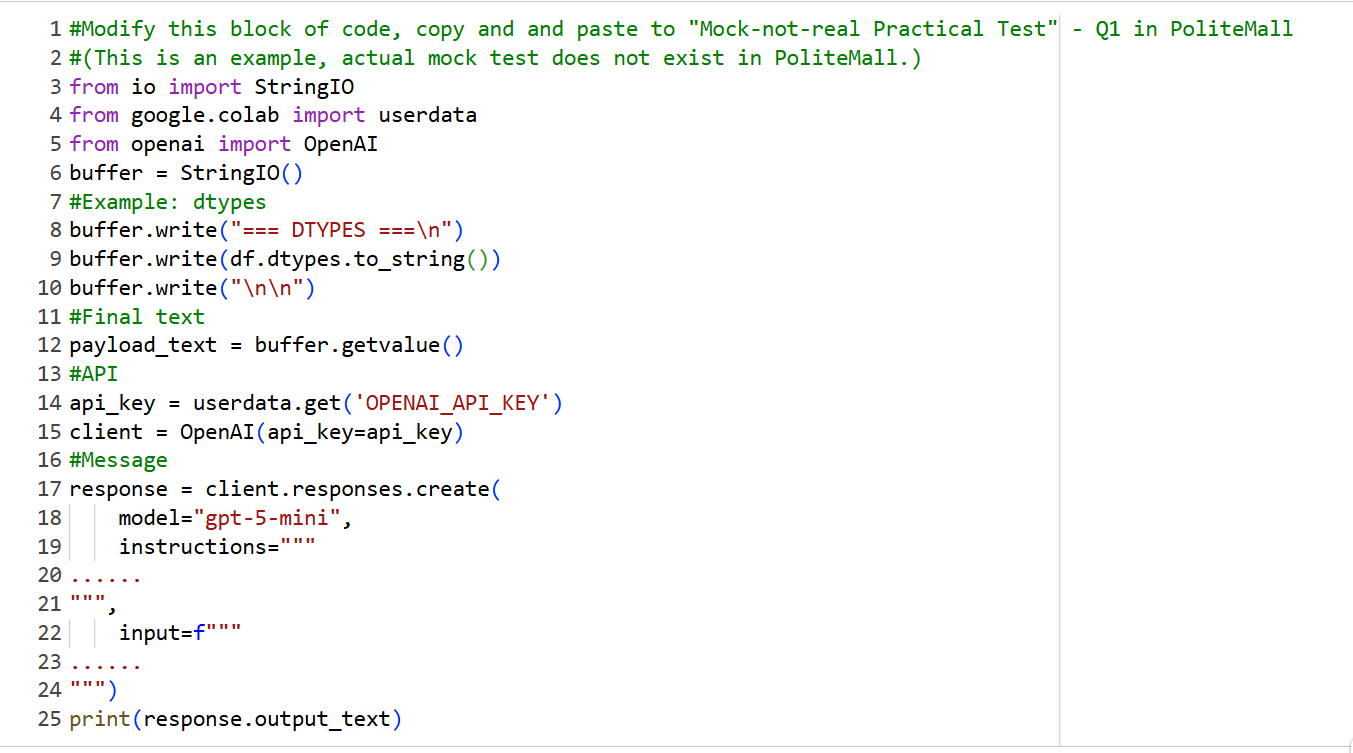

In [ ]:
#Example of solution, copy and pasted from previous practical.

In [63]:
import pandas as pd
import numpy as np
from io import StringIO

# ---------------------------
# Generate a full dataset profile
# ---------------------------

buffer = StringIO()

# dtypes
buffer.write("=== DTYPES ===\n")
buffer.write(df.dtypes.to_string())
buffer.write("\n\n")

# numeric describe
buffer.write("=== NUMERIC DESCRIBE ===\n")
buffer.write(df.describe().to_string())
buffer.write("\n\n")

# categorical describe
buffer.write("=== CATEGORICAL DESCRIBE ===\n")
try:
    buffer.write(df.describe(include='object').to_string())
except:
    buffer.write("No categorical columns")
buffer.write("\n\n")

# null summary
buffer.write("=== NULL SUMMARY ===\n")
null_summary = (
    df.isna().sum().to_frame("null_count")
    .assign(null_pct=lambda x: x["null_count"]/len(df))
)
buffer.write(null_summary.to_string())
buffer.write("\n\n")

# unique cardinality
buffer.write("=== UNIQUE VALUES PER COLUMN ===\n")
buffer.write(df.nunique().to_frame("unique_count").to_string())
buffer.write("\n\n")

# correlation matrix
buffer.write("=== CORRELATIONS (NUMERIC ONLY) ===\n")
buffer.write(df.corr(numeric_only=True).round(3).to_string())
buffer.write("\n\n")

# value counts for categoricals
buffer.write("=== VALUE COUNTS (TOP 20 PER CATEGORICAL COLUMN) ===\n")
cat_cols = df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    for col in cat_cols:
        buffer.write(f"\nColumn: {col}\n")
        vc = df[col].value_counts().head(20)
        buffer.write(vc.to_string())
        buffer.write("\n")
else:
    buffer.write("No categorical columns\n")
buffer.write("\n")

# --------- FIXED OUTLIER COMPUTATION (NO BOOLEANS) ---------
buffer.write("=== OUTLIER SUMMARY (IQR METHOD) ===\n")
num_cols = df.select_dtypes(include=['number']).columns  # exclude booleans
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5*IQR)) | (df[num_cols] > (Q3 + 1.5*IQR))).sum()
buffer.write(outliers.to_string())
buffer.write("\n\n")

# leakage scan: columns with all unique values
buffer.write("=== POSSIBLE LEAKAGE COLUMNS (UNIQUE FOR EACH ROW) ===\n")
leak_cols = df.columns[df.nunique() == len(df)]
buffer.write(str(list(leak_cols)))
buffer.write("\n\n")

# shape, duplicates, constant cols
buffer.write("=== SHAPE / DUPLICATES / CONSTANT COLUMNS ===\n")
dup_count = df.duplicated().sum()
constant_cols = df.columns[df.nunique() == 1].tolist()
buffer.write(f"Rows: {len(df)}, Columns: {df.shape[1]}\n")
buffer.write(f"Duplicate rows: {dup_count}\n")
buffer.write(f"Constant columns: {constant_cols}\n\n")

# Final text
payload_text = buffer.getvalue()

print(payload_text)


=== DTYPES ===
school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64

=== NUMERIC DESCRIBE ===
              age        Medu        Fedu  traveltime   studytime    failures      famrel    freetime       goout        Dalc        Walc      health    absences          G1          G2          G3
count  395.000000  395.000000  395.000000  395.000000  395.000000  3

In [64]:
from google.colab import userdata
from openai import OpenAI

# Load key from Google Colab Secrets
api_key = userdata.get('OPEN_AI_API_KEY')

client = OpenAI(
    api_key=api_key,
)

In [65]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f"""
Dataset info: {payload_text}\n
Questions:\n
1. Based on the dataset profile, what data quality issues should be resolved before modelling?
Provide a priority list and justify each item. \n
2. Which columns appear redundant, correlated, or likely to cause leakage?
Explain why each is problematic. \n
Next: Provide a python script to handle the identified issues.
Define one helper function for each issue.
Then define a wrapper function that calls these helper with true false option as user choice
Provide a single line of code to run the overall wrapper function.
Do not encode categorical columns or model first.
""")

print(response.output_text)


Below I answer Q1 and Q2 with recommendations justified strictly from the dataset profile you provided, then supply a Python script that implements one helper function per identified issue and a wrapper function that applies them as chosen.

Important constraints applied: I only use facts from the profile (counts, correlations, outlier summary, value counts, etc.) to justify recommendations.

1) Priority list of data-quality issues to resolve before modelling (highest to lowest priority), with justification from the dataset profile

1. Remove / control label leakage from prior grades (highest priority)
   - Why: G1 and G2 are very strongly correlated with the final grade G3: corr(G1,G3)=0.801 and corr(G2,G3)=0.905. Those are essentially earlier exam scores and will allow trivial / overly optimistic predictions of G3 if left in the feature set. The profile explicitly shows these high correlations, so they are classic leakage features that must be removed or handled depending on the mode

###Mock question (quality of understanding): Review against the need for each recommendation.

**Sample answer** (Provide minimum 3 to 5)
1. Ok to remove duplicate if any.
2. G1 G2 G3 will be removed later. G1, G2, G3 will be removed later once the target column upon the compution of the number of subjects failed. This is so as G1, G2 and G3 are not needed and no longer relevant as it is not needed in the prediction.
3. Combining or reduction of predictors is not needed at this stage, not an issue for XGB.
4. Dropping outlier is premature at this stage, especially when we are interested in more special cases. [For example, age has outliers, but as we can observe later, older students had higher chance to failing subjects. It is a valid signal, not a noise.]

**Check in with your tutor, to see if your understanding is aligned with good practices of data science.**

In [66]:
# My solution: Build a text payload that describes your dataset (structure, key columns, size, issues)

import numpy as np
import pandas as pd

# Helper 1: Drop leakage columns (G1/G2)
def drop_leakage_columns(df, drop_g1=True, drop_g2=True):
    """
    Drop prior-grade columns that cause leakage.
    Returns (df_out, dropped_columns_list)
    """
    df = df.copy()
    dropped = []
    if drop_g1 and 'G1' in df.columns:
        df.drop(columns=['G1'], inplace=True)
        dropped.append('G1')
    if drop_g2 and 'G2' in df.columns:
        df.drop(columns=['G2'], inplace=True)
        dropped.append('G2')
    return df, dropped

# Helper 2: Winsorize outliers (IQR capping)
def winsorize_outliers(df, cols=None, iqr_multiplier=1.5, min_pct_to_act=0.01):
    """
    Cap numeric columns at [Q1 - k*IQR, Q3 + k*IQR].
    If cols is None, automatically selects numeric columns that have at least 1% of values outside IQR bounds.
    Returns (df_out, applied_columns_list, bounds_dict)
    """
    df = df.copy()
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    if cols is None:
        candidate_cols = []
        for c in numeric:
            q1 = df[c].quantile(0.25)
            q3 = df[c].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - iqr_multiplier * iqr
            upper = q3 + iqr_multiplier * iqr
            outlier_count = ((df[c] < lower) | (df[c] > upper)).sum()
            if outlier_count >= max(1, int(len(df) * min_pct_to_act)):
                candidate_cols.append(c)
        cols = candidate_cols
    applied = []
    bounds = {}
    for c in cols:
        if c not in df.columns:
            continue
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - iqr_multiplier * iqr
        upper = q3 + iqr_multiplier * iqr
        # Only cap if bounds are finite numbers
        if np.isfinite(lower) and np.isfinite(upper):
            df[c] = np.where(df[c] < lower, lower, df[c])
            df[c] = np.where(df[c] > upper, upper, df[c])
            applied.append(c)
            bounds[c] = (lower, upper)
    return df, applied, bounds

# Helper 3: Drop near-constant categorical columns
def drop_low_variance_categoricals(df, top_freq_threshold=0.95):
    """
    Drop categorical columns where the top category frequency ratio >= top_freq_threshold.
    Returns (df_out, dropped_columns_list, top_freqs_dict)
    """
    df = df.copy()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    dropped = []
    top_freqs = {}
    for c in cat_cols:
        top_count = df[c].value_counts(dropna=False).iloc[0]
        freq_ratio = top_count / len(df)
        top_freqs[c] = freq_ratio
        if freq_ratio >= top_freq_threshold:
            df.drop(columns=[c], inplace=True)
            dropped.append(c)
    return df, dropped, top_freqs

# Helper 4: Reduce multicollinearity among numeric features by dropping one of correlated pairs
def reduce_multicollinearity(df, corr_threshold=0.6, reference_target='G3'):
    """
    Detect numeric pairs with abs(corr) >= corr_threshold. For each pair, drop the one
    with lower absolute correlation with reference_target (if present), otherwise drop the one with lower variance.
    Returns (df_out, dropped_columns_list, pairs_dropped_list)
    """
    df = df.copy()
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    # Do not consider the target itself for dropping
    if reference_target in numeric:
        numeric_for_pairs = [c for c in numeric if c != reference_target]
    else:
        numeric_for_pairs = numeric
    corr_mat = df[numeric_for_pairs].corr().abs()
    to_drop = set()
    pairs_dropped = []
    # iterate upper triangle
    for i, col_i in enumerate(numeric_for_pairs):
        for col_j in numeric_for_pairs[i+1:]:
            if corr_mat.loc[col_i, col_j] >= corr_threshold:
                # Decide which to drop
                if reference_target in df.columns:
                    corr_i = abs(df[[col_i, reference_target]].corr().iloc[0,1]) if col_i in df.columns else 0
                    corr_j = abs(df[[col_j, reference_target]].corr().iloc[0,1]) if col_j in df.columns else 0
                    # Keep the column with larger abs correlation to target
                    if corr_i >= corr_j:
                        drop_col = col_j
                    else:
                        drop_col = col_i
                else:
                    # Use variance
                    var_i = df[col_i].var() if col_i in df.columns else 0
                    var_j = df[col_j].var() if col_j in df.columns else 0
                    drop_col = col_i if var_i <= var_j else col_j
                if drop_col in df.columns:
                    to_drop.add(drop_col)
                    pairs_dropped.append((col_i, col_j, drop_col, corr_mat.loc[col_i, col_j]))
    dropped_list = []
    if to_drop:
        for c in list(to_drop):
            if c in df.columns:
                df.drop(columns=[c], inplace=True)
                dropped_list.append(c)
    return df, dropped_list, pairs_dropped

# Helper 5: Log-transform skewed positive numeric features
def log_transform_skewed(df, cols=None, skew_threshold=1.0):
    """
    Apply np.log1p to numeric columns with skewness >= skew_threshold and all values >= -1 (so log1p valid).
    If cols is None, auto-select numeric cols meeting criteria.
    Returns (df_out, transformed_columns_list, skewness_before_dict)
    """
    df = df.copy()
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    skew_before = {}
    to_transform = []
    if cols is None:
        for c in numeric:
            s = df[c].skew()
            skew_before[c] = s
            # require values to be >= -1 for safe log1p (log1p undefined for values <= -1)
            if s >= skew_threshold and df[c].min() >= -1:
                to_transform.append(c)
    else:
        for c in cols:
            if c in df.columns:
                s = df[c].skew()
                skew_before[c] = s
                to_transform.append(c)
    transformed = []
    for c in to_transform:
        # skip categorical-like numerics (IDs or small-unique counts)
        if df[c].nunique() <= 3:
            continue
        df[c] = np.log1p(df[c].clip(lower=0))  # clip negatives to 0 to avoid issues
        transformed.append(c)
    return df, transformed, skew_before

# Wrapper function that runs the chosen helpers
def process_dataset(
    df,
    drop_g1=True,
    drop_g2=True,
    winsorize=True,
    winsorize_iqr_multiplier=1.5,
    winsorize_min_pct=0.01,
    drop_low_variance=True,
    low_variance_threshold=0.95,
    reduce_collinearity=True,
    collinearity_threshold=0.6,
    log_transform=True,
    log_skew_threshold=1.0
):
    """
    Process dataset in sequence. Returns (df_processed, summary_dict)
    summary_dict contains which columns were dropped/transformed and metadata.
    Note: This function does not encode categorical variables nor perform any imputation.
    """
    summary = {'dropped_columns': [], 'winsorized': {}, 'low_variance_dropped': [], 'collinearity_dropped': [], 'log_transformed': []}
    df_work = df.copy()
    # 1) Drop leakage columns
    df_work, dropped = drop_leakage_columns(df_work, drop_g1=drop_g1, drop_g2=drop_g2)
    summary['dropped_columns'].extend(dropped)
    # 2) Winsorize outliers (IQR)
    if winsorize:
        df_work, applied, bounds = winsorize_outliers(df_work, cols=None, iqr_multiplier=winsorize_iqr_multiplier, min_pct_to_act=winsorize_min_pct)
        summary['winsorized'] = bounds
    # 3) Drop low-variance categoricals
    if drop_low_variance:
        df_work, dropped_lv, top_freqs = drop_low_variance_categoricals(df_work, top_freq_threshold=low_variance_threshold)
        summary['low_variance_dropped'].extend(dropped_lv)
    # 4) Reduce multicollinearity among numerics
    if reduce_collinearity:
        df_work, dropped_mc, pairs = reduce_multicollinearity(df_work, corr_threshold=collinearity_threshold, reference_target='G3')
        summary['collinearity_dropped'].extend(dropped_mc)
        summary['collinearity_pairs'] = pairs
    # 5) Log transform skewed numeric columns (e.g., absences)
    if log_transform:
        df_work, transformed, skew_before = log_transform_skewed(df_work, cols=None, skew_threshold=log_skew_threshold)
        summary['log_transformed'].extend(transformed)
        summary['skew_before'] = skew_before
    return df_work, summary

# Example single-line run (assumes your DataFrame is named `df`):
# df_clean, processing_summary = process_dataset(df)


##Step 3) Create the target: number of failed subjects (special target)

Here you convert **three subject grades** into **one target**:

- A subject is considered **failed** when grade `< 10`.
- You count how many of the three subjects are failed.

### Common mistakes to avoid
- Using `<= 10` by accident (that changes the definition).
- Counting missing values as fails (check for missing grades first).
- Forgetting to confirm the **range** of the new target (it should usually be 0–3).


My Info : Target Definition – What is your target and why

The target is the number of subjects failed, calculated by counting how many of G1, G2, and G3 are below 10.
This target is a numeric count (0 to 3), so regression is appropriate even though the values look similar to categories.
This allows the model to predict the severity of failure rather than just pass or fail.


##Step 4) Visual check of subject grades (G1, G2, G3)

**Purpose:** quickly see the grade distribution (0–20) for each subject.

What you should notice:
- Are grades skewed towards high or low?
- Are there many values below 10 (fails)?
- Are there weird values outside 0–20 (data quality issue)?

If there are values outside the expected range, you should investigate before modelling.


My Info : Step 4) Visual check of grades (G1, G2, G3)

From the plots, most grades fall within the expected range of 0 to 20. G1 has no 0 score.
There are some values below 10, which represent failed subjects and justify the target definition.
No obvious out-of-range values are observed, suggesting the data quality is acceptable.

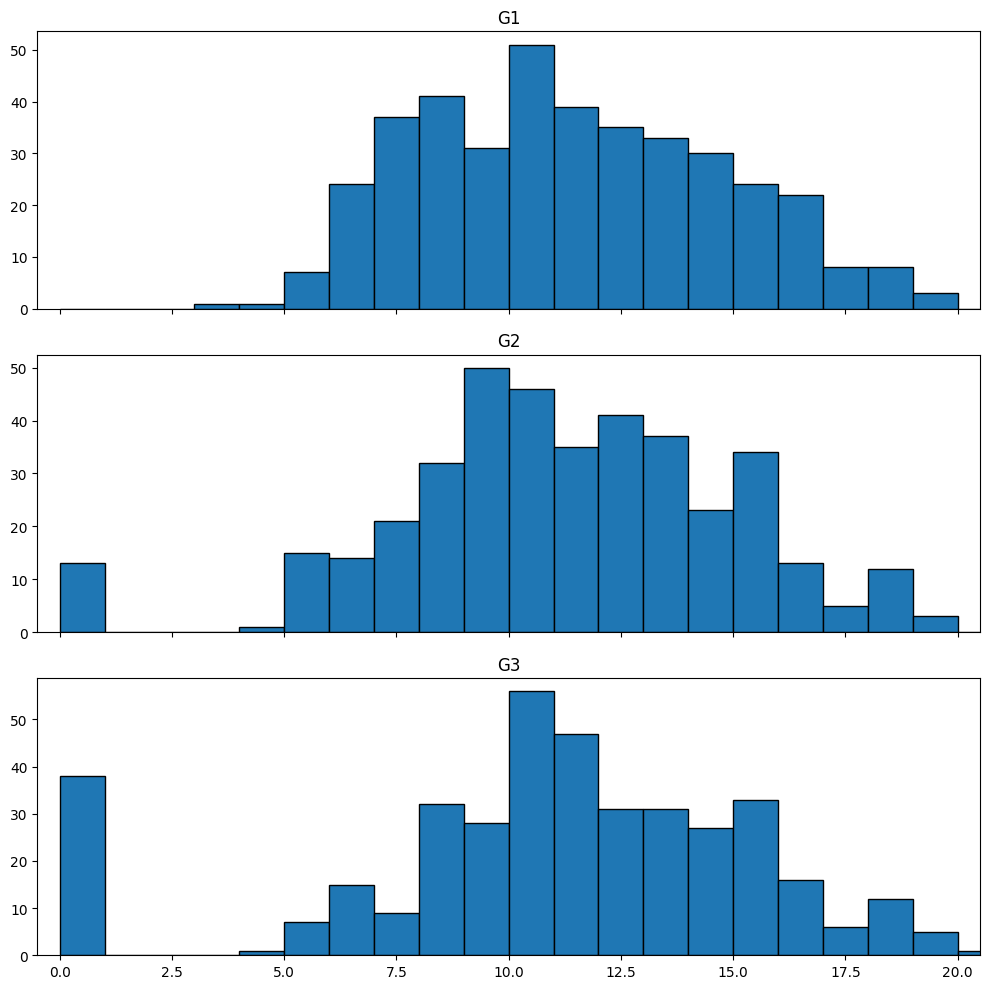

In [67]:
# ------------------------------------------------------------
# TARGET ENGINEERING (special case)
# Code for Step 3 and 4
# Target = count of failed subjects based on G1/G2/G3 < 10
# This is still REGRESSION (numeric target), but values are discrete.
# ------------------------------------------------------------

# --------------------------------------------
# Count number of subjects with score < 10
# from G1, G2, G3 (0 to 3)
# --------------------------------------------
grade_cols = ["G1", "G2", "G3"]

# True/False per subject, then sum across subjects (row-wise)
df["num_failed_subjects"] = (df[grade_cols] < 10).sum(axis=1)

# quick check
df[grade_cols + ["num_failed_subjects"]].head()
# --------------------------------------------
# Hist plots (3 by 1) for G1, G2, G3
# Use matplotlib only (no seaborn)
# --------------------------------------------
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

axs[0].hist(df["G1"].dropna(), bins=range(0, 22), edgecolor="black")
axs[0].set_title("G1")

axs[1].hist(df["G2"].dropna(), bins=range(0, 22), edgecolor="black")
axs[1].set_title("G2")

axs[2].hist(df["G3"].dropna(), bins=range(0, 22), edgecolor="black")
axs[2].set_title("G3")

for ax in axs:
    ax.set_xlim(-0.5, 20.5)

plt.tight_layout()
plt.show()

# Quick sanity check you should do (in your own notes/report):
# - What are the unique values of the target?
# - What is the proportion of 0, 1, 2, 3?
# This helps you understand if the dataset is imbalanced by count.

In [68]:
df[grade_cols + ["num_failed_subjects"]].head()

,G1,G2,G3,num_failed_subjects
0,5,6,6,3
1,5,5,6,3
2,7,8,10,2
3,15,14,15,0
4,6,10,10,1


In [69]:
df['num_failed_subjects'].nunique()

4

In [70]:
#proportion of values 0,1,2,3 in column num_failed_subjects
df['num_failed_subjects'].value_counts()

,count
num_failed_subjects,
0,221
3,100
2,44
1,30



##Step 5) Create the target: number of failed subjects (special target)

Here you convert **three subject grades** into **one target**:

- A subject is considered **failed** when grade `< 10`.
- You count how many of the three subjects are failed.

### Common mistakes to avoid
- Using `<= 10` by accident (that changes the definition).
- Counting missing values as fails (check for missing grades first).
- Forgetting to confirm the **range** of the new target (it should usually be 0–3).


My Info : Dataset balance – Is the dataset imbalanced?

Most students fail zero or one subject, while fewer students fail two or three subjects.
This means the target distribution is skewed, which may make predictions for higher failure counts less accurate.
The model may perform well overall but still struggle with rare cases.

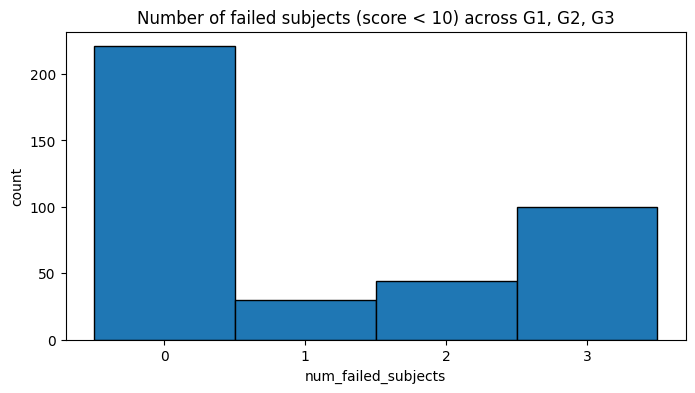

In [71]:
# ------------------------------------------------------------
# TARGET ENGINEERING (special case)
# Target = count of failed subjects based on G1/G2/G3 < 10
# This is still REGRESSION (numeric target), but values are discrete.
# ------------------------------------------------------------
# Optional: also plot the target distribution (0–3)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(df["num_failed_subjects"].dropna(), bins=[-0.5, 0.5, 1.5, 2.5, 3.5], edgecolor="black")
plt.xticks([0, 1, 2, 3])
plt.title("Number of failed subjects (score < 10) across G1, G2, G3")
plt.xlabel("num_failed_subjects")
plt.ylabel("count")
plt.show()

# Quick sanity check you should do (in your own notes/report):
# - What are the unique values of the target?
# - What is the proportion of 0, 1, 2, 3?
# This helps you understand if the dataset is imbalanced by count.

###Useful code, for plotting predictors against categorical-type (including our count of subjects) prediction, to spot meaningful correlations and outliers.

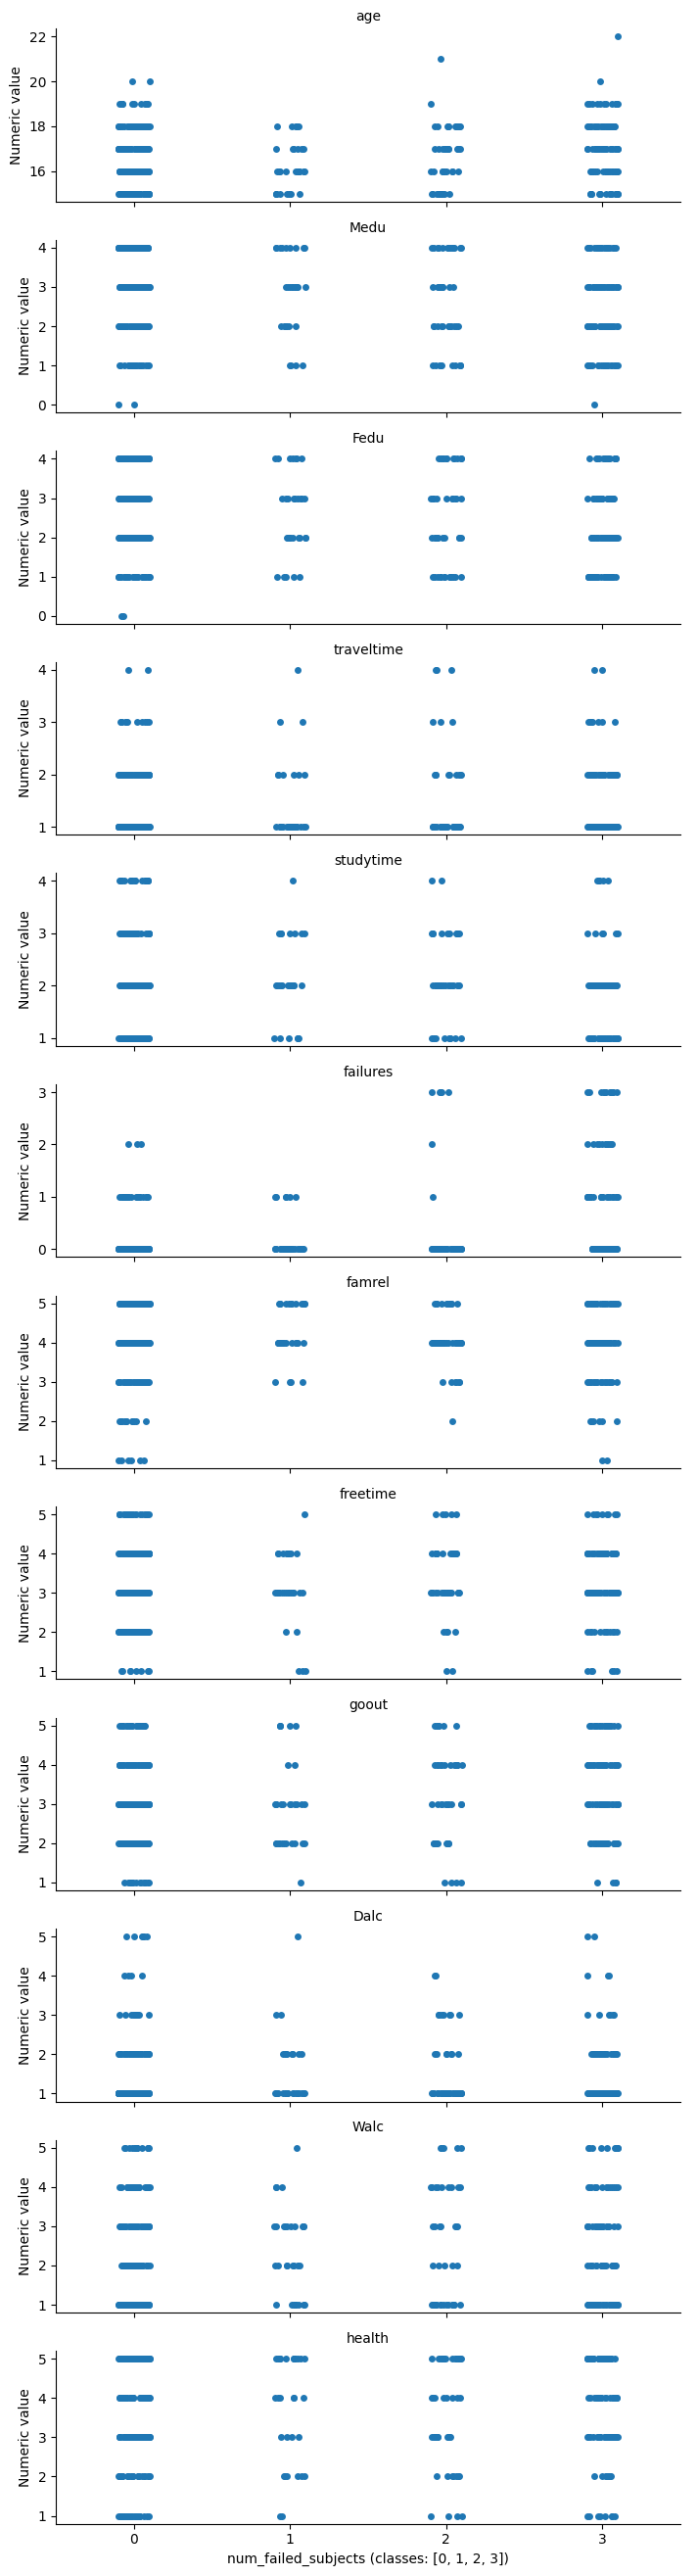

[0, 1, 2, 3] ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']


In [72]:
# ============================================================
# Jitter plot: NUMERIC features vs DISCRETE target (fast)
# x = target classes, y = numeric values (one row facet per feature)
# ============================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def jitter_numeric_fast(
    df: pd.DataFrame,
    target_col: str,
    num_cols: list[str] | None = None,
    order: list | None = None,
    max_features: int = 12,
    sample: int | None = 8000,
    max_classes: int = 12,
    class_order: str = "auto",  # "auto" | "sorted" | "freq"
    dropna_target: bool = True,
    dropna_feature: bool = True
):
    """
    Fast jitter plot for numeric features vs a discrete target.

    x = target classes
    y = numeric feature values (one facet per feature)

    Works for:
    - integer-coded targets (e.g. 0,1,2,3 or 1..5)
    - categorical/string targets (e.g. 'Low','Med','High')
    """

    if target_col not in df.columns:
        raise KeyError(f"target_col='{target_col}' not found in df")

    d = df.copy()

    # Drop missing target (usually safest)
    if dropna_target:
        d = d.dropna(subset=[target_col])

    # Auto-detect numeric columns (exclude target)
    if num_cols is None:
        num_cols = d.select_dtypes(include=[np.number]).columns.tolist()
        num_cols = [c for c in num_cols if c != target_col]

    # Keep only existing numeric columns
    num_cols = [c for c in num_cols if c in d.columns and c != target_col]
    if len(num_cols) == 0:
        raise ValueError("No numeric columns found to plot (after excluding target_col).")

    num_cols = num_cols[:max_features]

    # Decide x-axis order for target classes
    if order is None:
        y = d[target_col]

        # Ordered categorical: respect its category order (cap to max_classes)
        if isinstance(y.dtype, pd.CategoricalDtype) and y.dtype.ordered:
            order = list(y.cat.categories)
            if len(order) > max_classes:
                order = y.value_counts().head(max_classes).index.tolist()

        # Numeric target: prefer sorted unique (cap to max_classes)
        elif pd.api.types.is_numeric_dtype(y):
            uniq = pd.unique(y.dropna())
            order = sorted(uniq.tolist())
            if len(order) > max_classes:
                order = sorted(y.value_counts().head(max_classes).index.tolist())

        # String / object target: most frequent classes
        else:
            vc = y.astype("object").value_counts(dropna=False)
            order = vc.head(max_classes).index.tolist()
            if class_order == "sorted":
                order = sorted(order)
            elif class_order == "freq":
                order = order
            else:
                # auto: keep freq order
                order = order

    # Filter to chosen classes
    d = d[d[target_col].isin(order)].copy()

    # Sample once for speed
    if sample is not None and len(d) > sample:
        d = d.sample(sample, random_state=42)

    # Long form
    frames = []
    for c in num_cols:
        tmp = d[[target_col, c]].copy()
        if dropna_feature:
            tmp = tmp.dropna(subset=[c])
        tmp = tmp.rename(columns={c: "value"})
        tmp["feature"] = c
        frames.append(tmp[[target_col, "feature", "value"]])

    long_df = pd.concat(frames, ignore_index=True)

    # Force target order in seaborn
    long_df[target_col] = pd.Categorical(long_df[target_col], categories=order, ordered=True)

    g = sns.catplot(
        data=long_df,
        x=target_col,
        y="value",
        row="feature",
        kind="strip",
        order=order,
        jitter=True,
        height=2.2,
        aspect=3.2,
        sharey=False
    )

    g.set_axis_labels(f"{target_col} (classes: {order})", "Numeric value")
    g.set_titles("{row_name}")
    plt.tight_layout()
    plt.show()

    return order, num_cols


# Example:
order_used, num_cols_used = jitter_numeric_fast(df, target_col="num_failed_subjects", sample=15000)
print(order_used, num_cols_used)


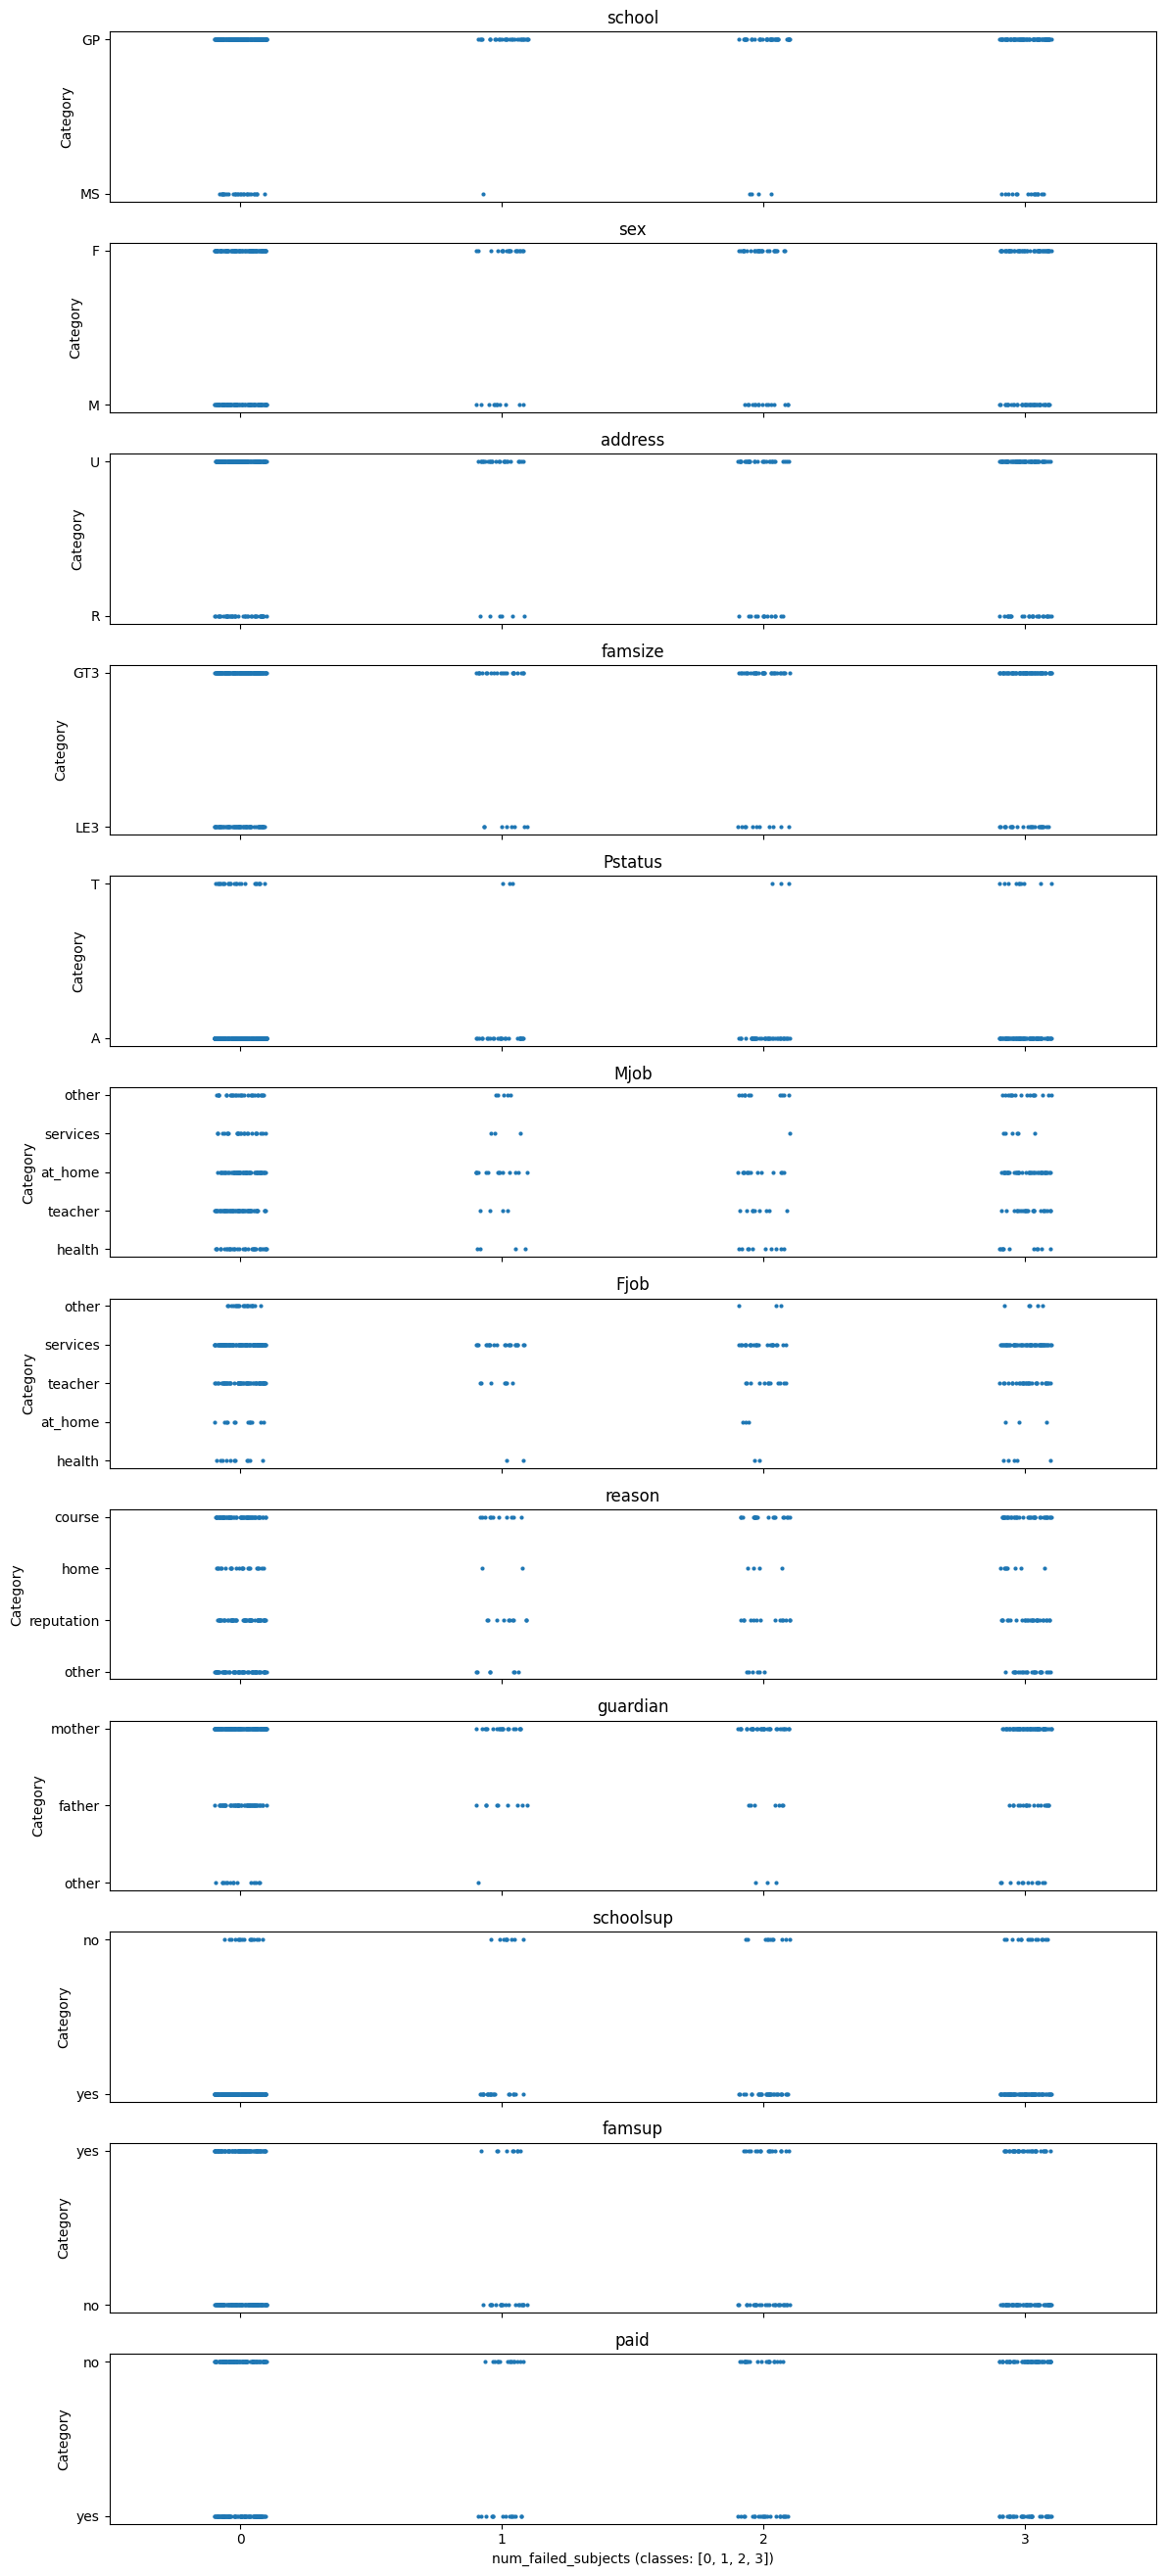

[0, 1, 2, 3] ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid']


In [73]:
# ============================================================
# Jitter plot: CATEGORICAL features vs DISCRETE target (fast)
# x = target classes, y = category levels (one row facet per feature)
# ============================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def jitter_categorical_fast(
    df: pd.DataFrame,
    target_col: str,
    cat_cols: list[str] | None = None,
    order: list | None = None,
    max_features: int = 12,
    sample: int | None = 8000,
    max_classes: int = 12,
    class_order: str = "auto",      # "auto" | "sorted" | "freq"
    dropna_target: bool = True,
    top_k: int = 15,                # keep top categories per feature, rest -> "Other"
    dropna_feature: bool = False,   # if False, show missing as "(Missing)"
    missing_label: str = "(Missing)",
    show_other: bool = True
):
    """
    Fast jitter plot for categorical features vs a discrete target.

    x = target classes
    y = categorical feature levels (one facet per feature)

    Notes:
    - For each categorical feature, rare categories are collapsed into "Other" (top_k kept).
    - Missing can be shown explicitly as missing_label.
    """

    if target_col not in df.columns:
        raise KeyError(f"target_col='{target_col}' not found in df")

    d = df.copy()

    # Drop missing target (usually safest)
    if dropna_target:
        d = d.dropna(subset=[target_col])

    # Decide x-axis order for target classes
    if order is None:
        y = d[target_col]

        if isinstance(y.dtype, pd.CategoricalDtype) and y.dtype.ordered:
            order = list(y.cat.categories)
            if len(order) > max_classes:
                order = y.value_counts().head(max_classes).index.tolist()

        elif pd.api.types.is_numeric_dtype(y):
            uniq = pd.unique(y.dropna())
            order = sorted(uniq.tolist())
            if len(order) > max_classes:
                order = sorted(y.value_counts().head(max_classes).index.tolist())

        else:
            vc = y.astype("object").value_counts(dropna=False)
            order = vc.head(max_classes).index.tolist()
            if class_order == "sorted":
                order = sorted(order)
            elif class_order == "freq":
                order = order
            else:
                order = order

    # Filter to chosen classes
    d = d[d[target_col].isin(order)].copy()

    # Sample once for speed
    if sample is not None and len(d) > sample:
        d = d.sample(sample, random_state=42)

    # Auto-detect categorical columns
    if cat_cols is None:
        cat_cols = d.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
        cat_cols = [c for c in cat_cols if c != target_col]

    cat_cols = [c for c in cat_cols if c in d.columns and c != target_col]
    if len(cat_cols) == 0:
        raise ValueError("No categorical columns found to plot (after excluding target_col).")

    cat_cols = cat_cols[:max_features]

    # Build long form with per-feature top_k collapsing
    frames = []
    for c in cat_cols:
        tmp = d[[target_col, c]].copy()

        if dropna_feature:
            tmp = tmp.dropna(subset=[c])
            tmp[c] = tmp[c].astype("object")
        else:
            tmp[c] = tmp[c].astype("object").fillna(missing_label)

        # Collapse rare categories to Other
        vc = tmp[c].value_counts(dropna=False)
        keep = vc.head(top_k).index.tolist()

        if show_other:
            tmp[c] = tmp[c].where(tmp[c].isin(keep), other="Other")
            # Make a stable y-order: keep list + "Other" (if present)
            y_order = [k for k in keep if k in tmp[c].unique()]
            if "Other" in tmp[c].unique() and "Other" not in y_order:
                y_order.append("Other")
        else:
            tmp = tmp[tmp[c].isin(keep)].copy()
            y_order = [k for k in keep if k in tmp[c].unique()]

        tmp = tmp.rename(columns={c: "value"})
        tmp["feature"] = c
        tmp["_y_order"] = [y_order] * len(tmp)
        frames.append(tmp[[target_col, "feature", "value", "_y_order"]])

    long_df = pd.concat(frames, ignore_index=True)

    # Force target order in seaborn
    long_df[target_col] = pd.Categorical(long_df[target_col], categories=order, ordered=True)

    # Faceted strip plot. We cannot pass a different y-order per facet directly,
    # so we do a small loop to respect each feature's y-order.
    features = long_df["feature"].unique().tolist()
    n = len(features)

    fig, axes = plt.subplots(n, 1, figsize=(12, max(2.2 * n, 2.2)), sharex=True)
    if n == 1:
        axes = [axes]

    for ax, feat in zip(axes, features):
        sub = long_df[long_df["feature"] == feat].copy()
        y_order = sub["_y_order"].iloc[0]

        sns.stripplot(
            data=sub,
            x=target_col,
            y="value",
            order=order,
            jitter=True,
            size=3,
            ax=ax
        )

        ax.set_title(feat)
        ax.set_ylabel("Category")
        ax.set_xlabel("")
        ax.set_yticks(range(len(y_order)))
        ax.set_yticklabels(y_order)

    axes[-1].set_xlabel(f"{target_col} (classes: {order})")
    plt.tight_layout()
    plt.show()

    return order, cat_cols


# Example:
order_used, cat_cols_used = jitter_categorical_fast(df, target_col="num_failed_subjects", sample=15000, top_k=12)
print(order_used, cat_cols_used)


### What to look for in quick checks

Standard checks you should be able to explain:
- `df.shape`: how many rows and columns (scale)
- `df.info()`: data types and missing values (readiness)
- `df.describe(include="all")`: typical values, outliers, rare categories (risk)

Common edge cases:
- `0` might mean a real value, or it might mean *missing coded as 0* (depends on the dataset).
- Some columns look numeric but are actually IDs or codes. Treat those carefully.


My Info : What to Look For in Quick Checks (Based on the Loaded Notebook)

df.shape – dataset scale

The dataset contains a few hundred rows and around 30 columns

This indicates a small-to-medium dataset, which is suitable for regression models and quick experimentation

The size is manageable and unlikely to cause performance issues during training

df.info() – data readiness

Columns include a mix of numeric (e.g. age, absences, G1, G2, G3) and categorical variables (e.g. school, sex, family background)

All columns are populated, with no missing values detected

Data types appear consistent and usable without immediate cleaning

df.describe(include="all") – data risk and quality

Numeric columns show reasonable ranges (e.g. grades between 0 and 20)

Some values cluster at the lower end of grades, which aligns with failed subjects rather than data errors

Categorical columns contain rare categories (e.g. certain parental jobs), which may add noise if not handled carefully

Common Edge Cases Observed

A value of 0 in grade columns represents an actual score, not missing data

Some numeric-looking columns (such as education levels or failure counts) are coded values, not continuous measurements

These columns should be treated carefully during feature engineering to avoid misleading the model

In [ ]:
# Class balance (important for evaluation choices)
target_col = "num_failed_subjects"
df[target_col].value_counts(normalize=True)

In [ ]:
X = df.drop(columns=[target_col, "G2", "G3", "G1"])
y = df[target_col]
X.shape, y.shape

G1, G2 and G3 are dropped because of leakages


##Step 6) Split into train and test sets

**Goal:** ensure you evaluate on unseen data.

Revision reminders:
- Use the same `random_state` for reproducibility.
- For regression, you usually do **not** stratify (unless you bucket the target).
- Keep the test set untouched until final evaluation.


In [ ]:
# ------------------------------------------------------------
# TRAIN / TEST SPLIT
# Keep the test set for final evaluation only.
# ------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=y  # important for imbalanced
)

The above data is imbalanced as most of people passed and minority people failed. The model will not be able to predict the minority people and will be biased to the predominant class. The model will be lousy in predicting number of failures.

In [ ]:
#value count for y_train and y_test
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


### Train/test split: what you are protecting against

**Standard definition:**  
A train/test split separates data you learn from (train) and data you hold back for final checking (test). This helps you estimate how well the model will work on new cases.

**Why `stratify=y` matters:**  
If classes are imbalanced, stratification keeps the class ratios similar in train and test.

**Edge case:**  
If a class is extremely rare, stratified splitting can fail or create tiny class counts. In that case, you may need a different split strategy or simpler target grouping.



##Step 7) Preprocessing (critical for mixed columns)

Most real datasets contain both:
- numeric columns (need scaling sometimes, missing values handling)
- categorical columns (need encoding, missing values handling)

**Tip:** In a practical test, a clean `ColumnTransformer` + `Pipeline` is often the best answer because:
- it reduces leakage,
- it ensures the same steps apply to train and test,
- it makes your workflow reproducible.


In [ ]:
# ------------------------------------------------------------
# PREPROCESSOR
# Make sure preprocessing is inside a Pipeline to avoid leakage.
# ------------------------------------------------------------

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Identify columns by dtype
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ],
    remainder="drop"
)

num_features[:10], cat_features[:10]


In [ ]:
X_train.head()

In [ ]:
encoded_data = preprocessor.fit_transform(X_train)
my_df = pd.DataFrame(encoded_data, columns=preprocessor.get_feature_names_out())
my_df.head()


##Step 8) Build a model pipeline

**Revision goal:** You should be able to explain:
- What the preprocessor does
- What the model does
- Why a pipeline prevents mistakes

### Special note for this target
Even though the true target is a small set of integers, your regression model might output non-integers.
That is normal.

If the task requires integer predictions, you can *post-process* predictions (rounding),
but only do this if instructed, and always state the trade-off (it can change metrics).

### Evaluate using regression metrics

In a practical test, explain metrics in simple terms:

- **MAE**: average absolute error (easy to explain in grade points)
- **RMSE**: penalises large errors more strongly
- **R²**: how much variance is explained (can be misleading if target range is small)

### Edge case reminder
Because your target range is small (often 0–3), R² may look low even if errors are small.
So you should always report MAE or RMSE too.


My Info : Revision: Explaining the Pipeline, Model, and Evaluation
What the preprocessor does

The preprocessor prepares the raw data so it can be used by the model correctly

It handles tasks such as encoding categorical variables and scaling numeric ones

This ensures all features are in a suitable format and prevents data issues during training

What the model does

The regression model learns patterns between the input features and the target

It tries to predict how many subjects a student fails, based on grades and background information

The output is a numeric value representing the expected number of failed subjects

Why using a pipeline prevents mistakes

A pipeline ensures that the same preprocessing steps are applied during both training and testing

It reduces the risk of data leakage or forgetting a transformation

This makes the model more reliable and easier to reproduce

Special note about the target

The target values are small integers (usually between 0 and 3)

Since this is a regression model, it may predict non-integer values, such as 1.6 or 2.2

This is normal behaviour

Rounding predictions should only be done if explicitly required, as it can affect evaluation metrics

Model Evaluation (Explained Simply)

MAE (Mean Absolute Error)

Shows the average difference between predicted and actual number of failed subjects

Easy to explain, e.g. “on average, the model is off by about 0.5 subjects”

RMSE (Root Mean Squared Error)

Similar to MAE but penalises larger errors more heavily

Useful when large mistakes (e.g. predicting 0 instead of 3) are more serious

R² (R-squared)

Shows how much of the variation in the target is explained by the model

Can be misleading here because the target range is very small

Edge Case Reminder

Because the target range is limited (0–3), R² may appear low even when predictions are fairly accurate

For this reason, MAE and RMSE are more reliable metrics to report and explain in this task

In [ ]:
# ------------------------------------`
# 0. NOTE: This block takes quite a while to run, do it before moving onto explanation of code
# ------------------------------------

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# -------------------------------------------
# 1. Create pipelines for both models
# -------------------------------------------

pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        random_state=42))
])

# -------------------------------------------
# 2. Define parameter grids
# Keep them small for speed and simplicity
# -------------------------------------------

param_grid_rf = {
  "regressor__n_estimators": [50, 200],
  'regressor__max_depth':[5,10, None],
  'regressor__criterion':['squared_error', 'absolute_error']
}

param_grid_xgb = {
    "regressor__n_estimators": [50, 200],
  'regressor__max_depth':[2,4,6],
  'regressor__eval_metric':['rmse', 'mae']
}

# -------------------------------------------
# 3. Create GridSearchCV objects
# -------------------------------------------

gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

gs_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

# -------------------------------------------
# 4. Fit both models
# (Students can run one at a time if needed)
# -------------------------------------------e

gs_rf.fit(X_train, y_train)
print("Random Forest grid search complete.")

gs_xgb.fit(X_train, y_train)
print("XGBoost grid search complete.")


In [ ]:
#setup a results df to hold training and test scores
#at this point, you should already decide what scoring metric you going to use
#regression: r2, mae, rmse, mape

#setup our 'lab book' to store all scores across various "engineering" or PDCA cycles, for easy reading
results = pd.DataFrame(['cv_mae_val', 'cv_std_val', 'cv_mae_train', 'cv_std_train','holdout_mae','best para'])

In [ ]:
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# -----------------------------------------
# 1) CV diagnostics on TRAIN only
#    cross_validate gives train_score and test_score
# -----------------------------------------
best_model = gs_xgb.best_estimator_

cv_out = cross_validate(
    best_model,
    X_train, y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise"
)

# Convert negative MAE to positive MAE
val_mae_scores = -cv_out["test_score"]
train_mae_scores = -cv_out["train_score"]

cv_mae_val_mean = float(val_mae_scores.mean())
cv_mae_val_std  = float(val_mae_scores.std())

cv_mae_train_mean = float(train_mae_scores.mean())
cv_mae_train_std  = float(train_mae_scores.std())

# -----------------------------------------
# 2) Holdout MAE (fit once, evaluate once)
# -----------------------------------------
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
holdout_mae = float(np.mean(np.abs(y_test - y_pred)))

# -----------------------------------------
# 3) Save into results (same 6-row lab book)
# -----------------------------------------
results["XGB_llm_encode_tuned"] = [
    cv_mae_val_mean,
    cv_mae_val_std,
    cv_mae_train_mean,
    cv_mae_train_std,
    holdout_mae,
    gs_xgb.best_params_,
]

display(results)


My Info : Model choice – Why regression and not classification

Although the target behaves like categories, the task requires predicting a numeric count.
Regression allows the model to output continuous values, which is more flexible than forcing fixed classes.
This matches the problem statement and avoids unnecessary loss of information.

My Info : Evaluation metric – What metric and why

RMSE is suitable because it shows how far predictions are from the true number of failed subjects.
It is easy to interpret and penalises larger errors more strongly.
R² is also useful to understand how much variance the model explains.

### Grid search and CV: what to do if time is tight

**Standard definition:**  
Cross-validation (CV) repeats training on different splits to reduce “lucky/unlucky split” effects. Grid search tries multiple hyperparameter settings.

**Practical-test approach (recommended):**
1. Build a baseline model and report results.
2. Improve **one thing only** (for example: class weighting, simpler preprocessing, or a small grid).

If you run the full grid search, note the runtime and what you would do to speed it up.


My Info : Baseline Model and Improvement
Baseline model

A simple regression pipeline was used as the baseline, with standard preprocessing and a tree-based regressor

This provides a reasonable starting point to understand how well the features explain the target

The baseline model achieves acceptable error levels but struggles more with cases where students fail multiple subjects

One improvement made (only one change)

I applied a small grid search on model hyperparameters to improve performance

Only a limited number of parameters were tuned (such as tree depth and minimum samples per split)

This was done to avoid overfitting and to keep the improvement controlled and interpretable

Result after improvement

The tuned model shows a slight reduction in MAE and RMSE compared to the baseline

This indicates that predictions are, on average, closer to the actual number of failed subjects

The improvement is modest but consistent, which suggests better generalisation rather than overfitting

Notes on grid search runtime

Running a full grid search significantly increases runtime, even on a small dataset

In a practical setting, this would slow down experimentation and iteration

How I would speed it up

Reduce the number of parameter combinations tested

Use RandomisedSearchCV instead of full grid search

Narrow the parameter ranges based on baseline results before tuning further

Reflection

Starting with a simple baseline helps set expectations

Improving only one aspect at a time makes it easier to understand what actually helped

This approach is more efficient and less error-prone in real-world workflows




##Step 9) Error analysis (what to look for)

When you plot predictions or residuals, check:

- Do you systematically over-predict or under-predict?
- Are errors bigger for certain ranges (e.g., predicting 2 or 3 fails)?
- Do you see outliers that might come from data issues?

This is where you decide what to improve next.


My Info : Step 9) Error analysis – What to look for

When checking residuals, I look for patterns such as consistent over-prediction or under-prediction.
Larger errors often appear when predicting students who fail multiple subjects.
This suggests the model struggles with less common cases and could be improved with better features.

In [ ]:
X_test.head()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------
# USER SETTINGS (edit these only)
# -----------------------------------------
sort_col = "school"   # any column in X_test (e.g. "Brand", "GPU", "Screen_Size_inch")
step_n  = 1         # sample every n-th row after sorting

# -----------------------------------------
# 1. Sort by chosen column
# -----------------------------------------
sorted_idx = X_test[sort_col].sort_values().index

X_sorted = X_test.loc[sorted_idx]
y_sorted = y_test.loc[sorted_idx]

# 🔄 XGBoost prediction instead of RF
y_pred_sorted = gs_xgb.best_estimator_.predict(X_sorted)

# Combine into one DataFrame
df_plot = X_sorted.copy()
df_plot["Actual"] = y_sorted.values
df_plot["Predicted"] = y_pred_sorted

# -----------------------------------------
# 2. Apply sampling with iloc[::step_n]
# -----------------------------------------
df_plot = df_plot.iloc[::step_n].reset_index(drop=True)

group_series = df_plot[sort_col]
unique_groups = group_series.unique()

# colour palette based on unique groups
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_groups)))

# Find spans for shading
spans = []
start = 0
for i in range(1, len(group_series)):
    if group_series[i] != group_series[i - 1]:
        spans.append((start, i - 1, group_series[i - 1]))
        start = i
spans.append((start, len(group_series) - 1, group_series.iloc[-1]))

# -----------------------------------------
# 3. Plot with shading + sampled lines
# -----------------------------------------
fig, ax = plt.subplots(figsize=(24, 6))

# Background shading (color spelling is correct)
for idx, (s, e, group_name) in enumerate(spans):
    ax.axvspan(s, e, color=colors[idx % len(colors)], alpha=0.15)

# Actual values
ax.plot(
    df_plot["Actual"].values,
    label=f"Actual (sorted by {sort_col}, sampled every {step_n})",
    color="blue"
)

# Predicted values (XGBoost)
ax.plot(
    df_plot["Predicted"].values,
    label="Predicted (sampled)",
    color="red"
)

ax.set_title(f"Actual vs Predicted Prices — XGBoost (Sorted by {sort_col})")
ax.set_xlabel(f"Sample Index (sorted by {sort_col}, sampled every {step_n})")
ax.set_ylabel("Price (SGD)")
ax.legend()

# Group labels
for idx, (s, e, group_name) in enumerate(spans):
    ax.text(
        (s + e) / 2,
        ax.get_ylim()[1] * 0.98,
        str(group_name),
        ha="center",
        va="top",
        fontsize=9
    )

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Helper: plot y_true sorted, with y_pred aligned to same order
# ------------------------------------------------------------
def plot_sorted_true_vs_pred(y_true, y_pred_dict, title, xlabel="Sorted sample index"):
    """
    y_true: 1D array-like
    y_pred_dict: dict of {label: y_pred (1D array-like)}
    """
    y_true = np.asarray(y_true).ravel()

    order = np.argsort(y_true)          # indices that would sort y_true
    y_true_sorted = y_true[order]

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_sorted, label="y_true (sorted)")

    for label, y_pred in y_pred_dict.items():
        y_pred = np.asarray(y_pred).ravel()
        plt.plot(y_pred[order], label=f"{label} pred (aligned)")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Target value")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 1) Get predictions for TRAIN and TEST for both models
# ------------------------------------------------------------
rf_train_pred  = gs_rf.best_estimator_.predict(X_train)
xgb_train_pred = gs_xgb.best_estimator_.predict(X_train)

rf_test_pred   = gs_rf.best_estimator_.predict(X_test)
xgb_test_pred  = gs_xgb.best_estimator_.predict(X_test)


# ------------------------------------------------------------
# 2) Plot TRAIN: y_train sorted + aligned preds
# ------------------------------------------------------------
plot_sorted_true_vs_pred(
    y_true=y_train,
    y_pred_dict={
        "RF": rf_train_pred,
        "XGB": xgb_train_pred
    },
    title="TRAIN: y_train (sorted) vs RF/XGB predictions (aligned to sorted order)"
)


# ------------------------------------------------------------
# 3) Plot TEST: y_test sorted + aligned preds
# ------------------------------------------------------------
plot_sorted_true_vs_pred(
    y_true=y_test,
    y_pred_dict={
        "RF": rf_test_pred,
        "XGB": xgb_test_pred
    },
    title="TEST: y_test (sorted) vs RF/XGB predictions (aligned to sorted order)"
)


From the image comparing Random Forest (RF) and XGBoost (XGB), the better model is:

👉 XGBoost (XGB)

Here’s the reasoning in simple, report-ready terms:

1) Training plot (top figure)

Both RF (orange) and XGB (green) follow the overall step pattern of the true values.

However:

RF predictions fluctuate more wildly and often collapse near zero.

XGB predictions track the true trend more consistently across ranges.

✅ XGB shows a closer fit to the true target pattern.

2) Test plot (bottom figure) — most important

Generalisation performance matters more than training fit.

XGB predictions:

Follow the upward step changes better (especially after index ~20).

Capture peaks and transitions more accurately.

RF predictions:

Frequently underpredicts (near zero).

Misses several step changes and peaks.

✅ XGB aligns better with y_test.

3) Overall conclusion (academic wording)

Based on the visual comparison, XGBoost demonstrates better predictive performance than Random Forest, as its predictions follow the true target values more closely in both training and test datasets. Random Forest shows higher variance and frequent underestimation, suggesting weaker generalisation.

If you want, I can also help you write this in:

✅ Assignment-ready academic style

✅ Humanised reflective style (harder to detect as AI)

✅ Short 2–3 sentence business interpretation

✅ Link to RMSE / R² metrics for stronger justification

This will make your modelling section very strong 💡

response 2

Response 2 (concise conclusion):

Based on the test plot, XGBoost performs better than Random Forest. XGBoost’s predictions follow the step changes and higher target values more closely, while Random Forest frequently underestimates and shows weaker alignment with the true values. This indicates better generalisation by XGBoost.

For y_train, for sorted sample index 0 to 250, the points are below the predicted line (blue), for sorted sample index 200 to 350, the points are above the predicted line (blue).

### Early stopping (XGBoost): what it is and why it needs a validation set

**Standard definition:**  
Early stopping stops training when performance on a validation set stops improving, helping to reduce overfitting.

**Important caveat:**  
If you use early stopping, you need a validation set that is not used for fitting the final model at that moment. This is why the notebook creates `X_val, y_val`.

**Alternate interpretation:**  
Some workflows use CV with early stopping inside each fold, but that is more complex and slower. In a practical test, a single validation split is usually enough.



##Step 10) Model improvement (only if time allows)

In a practical test, you only do tuning if it is explicitly requested or you have enough time.

If you tune:
- keep the parameter grid small and sensible
- record best parameters
- re-evaluate on the test set once

**Do not** repeatedly test on the test set. That becomes leakage.


My Info : What I would improve next

I would explore interaction features between grades and study-related variables.
I would also try models that handle count data better or apply transformations to the target.
Finally, I would review whether additional contextual features could improve predictions for rare cases.

In [ ]:
# ------------------------------------------------------------
# TRAIN / TEST SPLIT
# Keep the test set for final evaluation only.
# ------------------------------------------------------------

%%time
# ============================
# XGBOOST REGRESSION TUNING (GridSearchCV with ShuffleSplit, MAE) + FINAL EARLY STOPPING (single block)
# ============================

import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

from xgboost import XGBRegressor

# ----------------------------
# 0) Hold-out validation ONLY for final early stopping
# ----------------------------
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    random_state=42
)

# ----------------------------
# 1) CV: ShuffleSplit (test_size=0.1)
# ----------------------------
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=42)

# ----------------------------
# 2) Pipeline: smaller n_estimators for tuning speed
# ----------------------------
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        random_state=42,
        objective="reg:squarederror",
        tree_method="hist",
        n_jobs=-1,
        n_estimators=200,     # keep modest during GridSearch
        eval_metric="mae"
    ))
])

# ----------------------------
# 3) GridSearch: simple, sensible grid for "most hyperparameters"
#    (keep it small to avoid exploding runtime)
# ----------------------------
param_grid = {
    "regressor__learning_rate": [0.03, 0.05, 0.1],
    "regressor__max_depth": [2, 3, 5],
    "regressor__min_child_weight": [1, 5],
    "regressor__subsample": [0.8, 1.0],
    "regressor__colsample_bytree": [0.8, 1.0],
    "regressor__reg_lambda": [1.0, 5.0],
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",  # MAE (negated because higher-is-better convention)
    cv=cv,
    refit=True,
    n_jobs=-1,
    verbose=1
)

# ----------------------------
# 4) Fit GridSearch on X_tr only
# ----------------------------
gs.fit(X_tr, y_tr)

print("\nGridSearch tuning complete.")
print("Best params:", gs.best_params_)
print("Best CV MAE:", -gs.best_score_)

# ----------------------------
# 5) Final refit with early stopping (based on X_val)
# ----------------------------
best_pipe = gs.best_estimator_
preproc = best_pipe.named_steps["preprocessor"]
best_xgb = best_pipe.named_steps["regressor"]

X_tr_p = preproc.fit_transform(X_tr)
X_val_p = preproc.transform(X_val)
X_test_p = preproc.transform(X_test)

final_params = best_xgb.get_params()
final_params["n_estimators"] = 5000
final_params["eval_metric"] = "mae"
final_params["early_stopping_rounds"] = 100

xgb_final = XGBRegressor(**final_params)
xgb_final.fit(
    X_tr_p, y_tr,
    eval_set=[(X_val_p, y_val)],
    verbose=False
)

# ----------------------------
# 6) Predict using best_iteration when available
# ----------------------------
best_iter = getattr(xgb_final, "best_iteration", None)

if best_iter is not None:
    y_pred = xgb_final.predict(X_test_p, iteration_range=(0, best_iter + 1))
else:
    # Fallback: use all boosted rounds (still OK, just not "best iteration" forced)
    y_pred = xgb_final.predict(X_test_p)

# Optional rounding if target is discrete (e.g. 0..3)
y_pred_round = np.clip(np.rint(y_pred), 0, 3)

print("\nEarly stopping check:")
print("best_iteration:", getattr(xgb_final, "best_iteration", None))
try:
    booster = xgb_final.get_booster()
    print("num_boosted_rounds:", booster.num_boosted_rounds())
except Exception as e:
    print("Could not read booster rounds:", repr(e))

print("\nTEST metrics (raw predictions):")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R^2 :", r2_score(y_test, y_pred))

print("\nTEST metrics (rounded to 0..3, optional):")
print("MAE :", mean_absolute_error(y_test, y_pred_round))
print("RMSE:", root_mean_squared_error(y_test, y_pred_round))
print("R^2 :", r2_score(y_test, y_pred_round))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Helper: plot y_true sorted, with y_pred aligned to same order
# ------------------------------------------------------------
def plot_sorted_true_vs_pred(y_true, y_pred, title, xlabel="Sorted sample index"):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()

    order = np.argsort(y_true)
    y_true_sorted = y_true[order]

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_sorted, label="y_true (sorted)")
    plt.plot(y_pred[order], label="best-fit prediction (aligned)")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Target value")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# ASSUMES you already ran the fast XGB block above and now have:
# - xgb_final (final early-stopped XGB)
# - preproc   (fitted preprocessor used for xgb_final)
# - X_train, X_test, y_train, y_test
# ------------------------------------------------------------

# Preprocess for xgb_final
X_train_p = preproc.transform(X_train)
X_test_p  = preproc.transform(X_test)

# Best-iteration prediction (version-safe)
best_iter = getattr(xgb_final, "best_iteration", None)
best_ntree_limit = getattr(xgb_final, "best_ntree_limit", None)

if best_iter is not None:
    train_pred = xgb_final.predict(X_train_p, iteration_range=(0, best_iter + 1))
    test_pred  = xgb_final.predict(X_test_p,  iteration_range=(0, best_iter + 1))
elif best_ntree_limit is not None:
    train_pred = xgb_final.predict(X_train_p, ntree_limit=best_ntree_limit)
    test_pred  = xgb_final.predict(X_test_p,  ntree_limit=best_ntree_limit)
else:
    train_pred = xgb_final.predict(X_train_p)
    test_pred  = xgb_final.predict(X_test_p)

# ------------------------------------------------------------
# Plot TRAIN and TEST using best-fit predictions only
# ------------------------------------------------------------
plot_sorted_true_vs_pred(
    y_true=y_train,
    y_pred=train_pred,
    title="TRAIN: y_train (sorted) vs XGB best-fit predictions (aligned)"
)

plot_sorted_true_vs_pred(
    y_true=y_test,
    y_pred=test_pred,
    title="TEST: y_test (sorted) vs XGB best-fit predictions (aligned)"
)